In [1]:
import os
import random
import time
from shutil import copyfile

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as TM
import torchvision
import torchvision.transforms as T

from PIL import Image
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [2]:
# Predefined transformations for frequent use
Tensor2PILImage = T.ToPILImage()
PILImage2Tensor = T.ToTensor()

In [3]:
# Classes

CLASSES = ['Background', 'Neoplastic', 'Inflammatory', 'Connective', 'Dead', 'Epithelial']

num_of_classes = len(CLASSES)

CLASS_COLORS = [(0, 0, 0), (255, 0, 0), (255, 0, 255), (0, 255, 0), (0, 0, 255), (255, 255, 0)]

class_weights = [0.1, 1, 1, 1, 1, 1]

imagesize = 256

In [4]:
def get_device():
    """Return the appropriate device (CUDA or CPU) based on availability."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_device(x):
    """Send the tensor or model to the appropriate device."""
    device = get_device()
    return x.to(device)

print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [5]:
# Create a nested directory structure
parent_dir =   # Please enter the root directory for your project:

Save_folder_name = "CIS V1T07"
save_path = os.path.join(parent_dir, Save_folder_name)

input_path_1 = os.path.join(parent_dir, 'Part 1', 'Images', 'images.npy')
output_path_1 = os.path.join(parent_dir, 'Part 1', 'Masks', 'masks.npy')
input_path_2 = os.path.join(parent_dir, 'Part 2', 'Images', 'images.npy')
output_path_2 = os.path.join(parent_dir, 'Part 2', 'Masks', 'masks.npy')
input_path_3 = os.path.join(parent_dir, 'Part 3', 'Images', 'images.npy')
output_path_3 = os.path.join(parent_dir, 'Part 3', 'Masks', 'masks.npy')

#load image npy
image_1=np.load(input_path_1,mmap_mode='r')[:1000]
masks_1=np.load(output_path_1,mmap_mode='r')[:1000]

image_2=np.load(input_path_2,mmap_mode='r')[:1000]
masks_2=np.load(output_path_2,mmap_mode='r')[:1000]

image_3=np.load(input_path_3,mmap_mode='r')[:1000]
masks_3=np.load(output_path_3,mmap_mode='r')[:1000]

try:
    os.mkdir(save_path)
except OSError:
    pass


In [6]:
images = np.concatenate((image_1, image_2, image_3), axis=0)
masks = np.concatenate((masks_1, masks_2, masks_3), axis=0)

#print shape of image npy
print(image_1.shape, image_2.shape, image_3.shape, images.shape)
print(masks_1.shape, masks_2.shape, masks_3.shape, masks.shape)

(1000, 256, 256, 3) (1000, 256, 256, 3) (1000, 256, 256, 3) (3000, 256, 256, 3)
(1000, 256, 256, 6) (1000, 256, 256, 6) (1000, 256, 256, 6) (3000, 256, 256, 6)


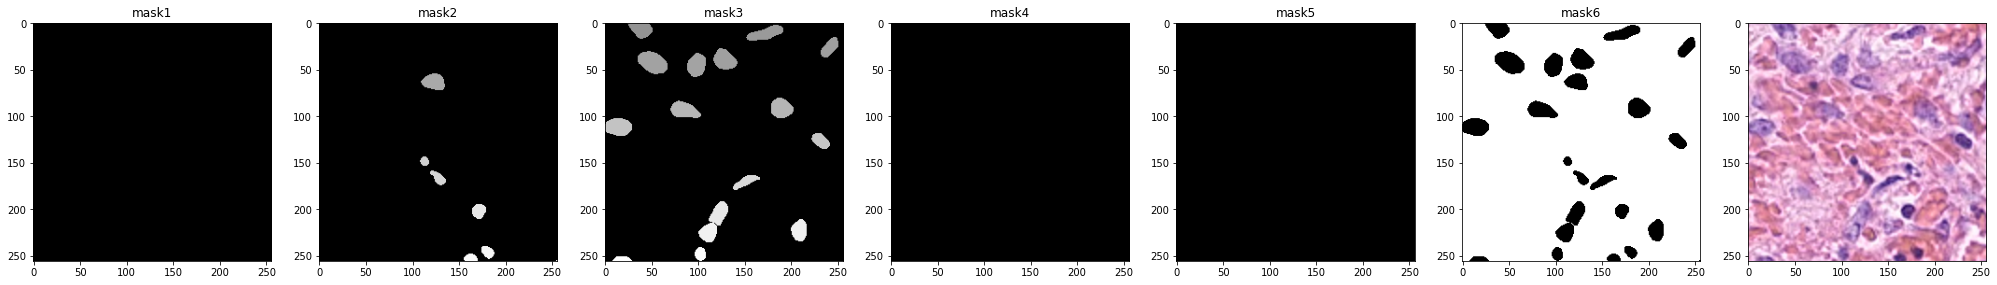

In [107]:
def Plot_image_sample(ind):
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 5))
    axes = axes.flatten()
    for i in range(6):#six data last one is flag, so we only need 0,1,2,3,4
        axes[i].imshow(masks[ind][:,:,i], cmap='gray')
        axes[i].set_title('mask'+str(i+1))
    axes[6]=plt.imshow(images.astype('int32')[ind])

Plot_image_sample(800)

In [8]:
def delete_no_cells_tiles(images, masks):
    del_ind = []
    for i in range(masks.shape[0]):
        if np.max(masks[i,:,:,:5])==0:
            del_ind.append(i)
    print(del_ind)
    images = np.delete(images, del_ind, 0)
    masks = np.delete(masks, del_ind, 0)
    return images, masks


images, masks = delete_no_cells_tiles(images, masks)

[584, 586, 604, 748, 750, 780, 811, 812, 813, 828, 830, 832, 833, 996, 998, 1544, 1679, 1680, 1724, 1749, 1750, 1752, 1753, 2236, 2546, 2735, 2754, 2762, 2778, 2780, 2784]


In [9]:
#print shape of image npy
print(image_1.shape, image_2.shape, image_3.shape, images.shape)
print(masks_1.shape, masks_2.shape, masks_3.shape, masks.shape)

(1000, 256, 256, 3) (1000, 256, 256, 3) (1000, 256, 256, 3) (2969, 256, 256, 3)
(1000, 256, 256, 6) (1000, 256, 256, 6) (1000, 256, 256, 6) (2969, 256, 256, 6)


In [10]:
def vectorize_3d_mask(masks):
    # Verify the shape of the mask_set
    if masks.shape[1:] != (imagesize, imagesize, 6):
        raise ValueError(f"Expected shape for each mask: ({imagesize}, {imagesize}, 6)")

    # Initialize the 2D mask array
    mask_2d = np.zeros(masks.shape[:3], dtype=int)

    # Apply mask channel indices, preferring lower index channels where overlaps occur
    for channel in range(len(CLASSES)-1):
        channel_mask = (masks[..., channel] != 0) & (mask_2d == 0)
        mask_2d[channel_mask] = channel + 1

    return np.expand_dims(mask_2d, axis=-1)

In [11]:
mask_2d = vectorize_3d_mask(masks)
images = np.uint8(images)

print(mask_2d.shape)
print(images.shape)

(2969, 256, 256, 1)
(2969, 256, 256, 3)


In [28]:
def get_images(images, masks, fold_num = 1, max_fold = 5):
    """Split images and masks based on the fold."""

    # Calculate the indices for training and validation splits
    num_samples = images.shape[0]
    start_val = int((fold_num - 1) / max_fold * num_samples)
    end_val = int(fold_num / max_fold * num_samples)

    train_images = np.concatenate((images[:start_val], images[end_val:]), axis=0)
    train_masks = np.concatenate((masks[:start_val], masks[end_val:]), axis=0)
    valid_images = images[start_val:end_val]
    valid_masks = masks[start_val:end_val]

    return train_images, train_masks, valid_images, valid_masks

def train_transforms(img_size):
    """Transforms/augmentations for training images and masks."""
    train_image_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(shear=0.4, mode=4, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.5, p=1.0),
        A.ShiftScaleRotate(scale_limit=0.4, rotate_limit=180, shift_limit=0.5, p=1.0),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, always_apply=True),
        A.Blur(blur_limit=3, p=0.2),
        A.Sharpen(alpha = 0.1, p=0.2)
    ])
    return train_image_transform


def valid_transforms(img_size):
    """Transforms/augmentations for validation images and masks."""
    return A.Compose([A.Resize(img_size, img_size, always_apply=True)])



class SegmentationDataset(Dataset):
    def __init__(self, images, masks, tfms):
        self.images = images
        self.masks = masks
        self.tfms = tfms


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]


        # Apply transformations
        transformed = self.tfms(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

        # Convert to tensors
        image = torch.from_numpy(np.transpose(image/255, (2, 0, 1))).float()
        mask = torch.from_numpy(np.transpose(mask, (2, 0, 1))).long()

        return image, mask

In [34]:
# Define constants for training
classes_to_train = CLASSES
batch_size = 15
fold_num = 1
max_fold = 5

# Load images and masks
train_images, train_masks, valid_images, valid_masks = get_images(images, mask_2d, fold_num = 1, max_fold = 5)

# Set up transformations
train_tfms = train_transforms(imagesize)
valid_tfms = valid_transforms(imagesize)

# Initialize datasets
train_dataset = SegmentationDataset(train_images, train_masks, train_tfms)
valid_dataset = SegmentationDataset(valid_images, valid_masks, valid_tfms)

# Configure data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=False)

# Access a batch of data
(train_data_inputs, train_data_targets) = next(iter(train_data_loader))
(valid_data_inputs, valid_data_targets) = next(iter(valid_data_loader))
print(train_images.shape, train_masks.shape, valid_images.shape, valid_masks.shape)
print(train_data_inputs.shape, train_data_targets.shape, train_data_inputs.dtype, train_data_targets.dtype)

(2376, 256, 256, 3) (2376, 256, 256, 1) (593, 256, 256, 3) (593, 256, 256, 1)
torch.Size([15, 3, 256, 256]) torch.Size([15, 1, 256, 256]) torch.float32 torch.int64


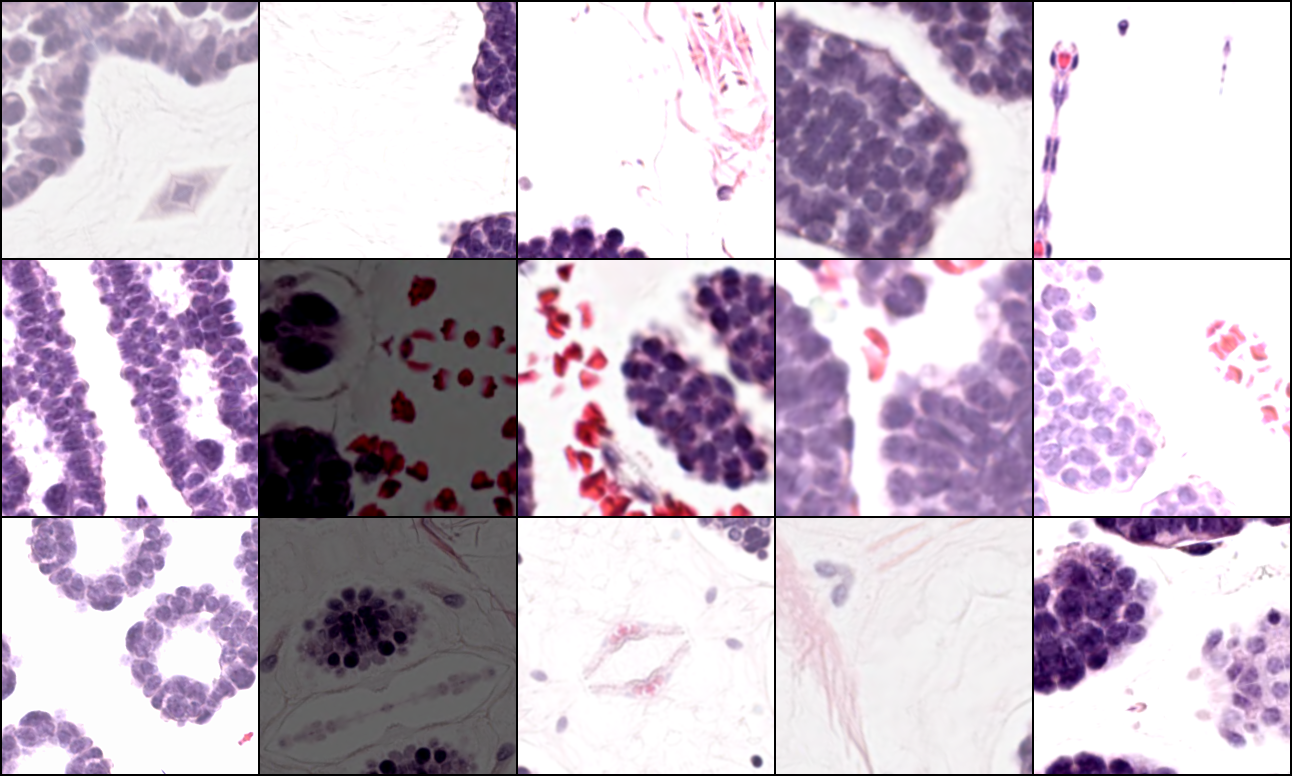

In [35]:
# Create a grid of input images
data_input_grid = torchvision.utils.make_grid(train_data_inputs, nrow=5)
# Convert the tensor to a PIL Image
Tensor2PILImage(data_input_grid)

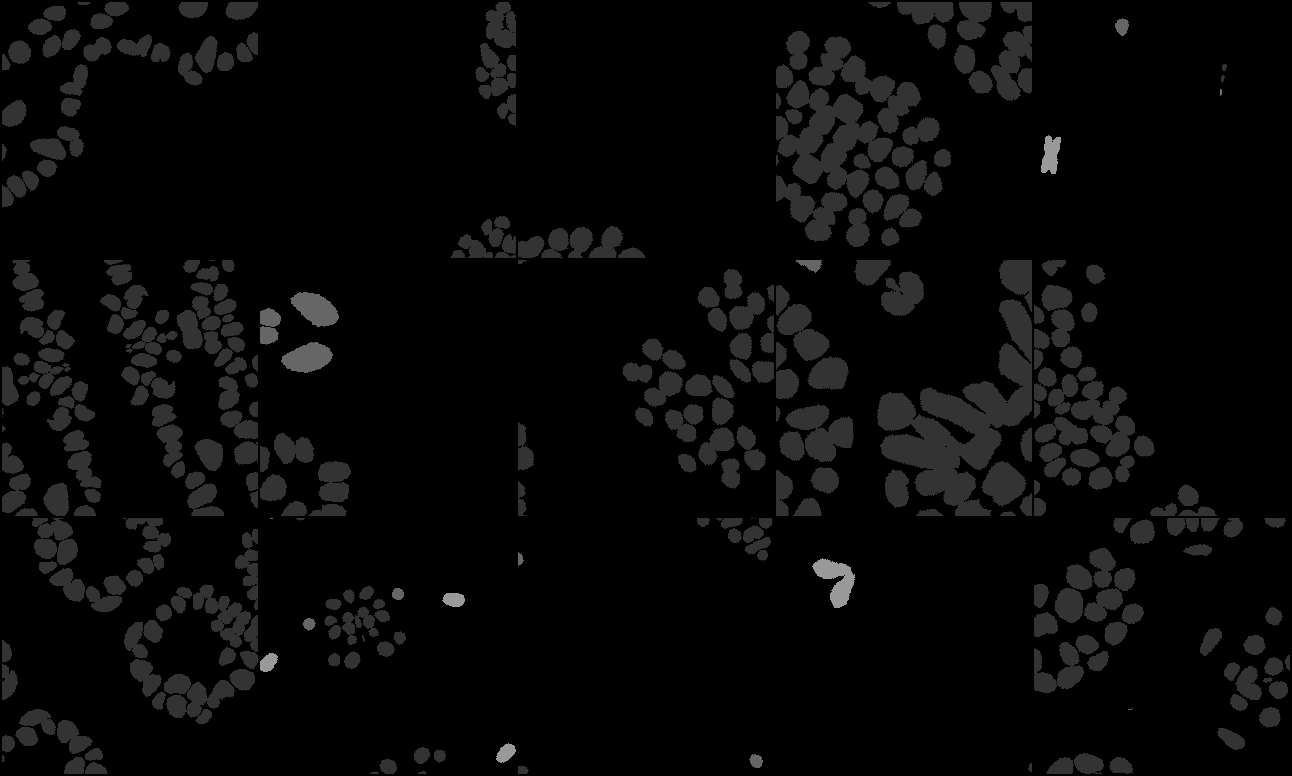

In [36]:
# Create a grid of output images
data_targets_grid = torchvision.utils.make_grid(train_data_targets / 5.0, nrow=5)
# Convert the tensor to a PIL Image
Tensor2PILImage(data_targets_grid)

In [38]:
# Initialize the model and move it to the defined device
model = smp.Unet("efficientnet-b7", encoder_weights='imagenet', classes=len(classes_to_train))
to_device(model)

# Perform a forward pass and check the output shape
print(model(to_device(train_data_inputs)).shape)

torch.Size([15, 6, 256, 256])


In [108]:
def IoUMetric(pred, gt, num_of_classes, weights=None, softmax=False):
    """Calculate the weighted mean Intersection over Union (IoU)."""
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)

    # One-hot encoding of ground truth
    gt = F.one_hot(gt.squeeze(1), num_classes=num_of_classes).permute(0, 3, 1, 2).float()

    # Computation of intersection and union
    intersection = torch.sum(gt * pred, dim=(2, 3))
    union = torch.sum(pred + gt, dim=(2, 3)) - intersection

    # Apply weights
    if weights is not None:
        intersection = weights * intersection
        union = weights * union


    # Compute IoU avoiding division by zero
    valid = union > 0
    iou = torch.zeros_like(union)
    iou[valid] = intersection[valid] / union[valid]

    # Mean IoU across all valid entries
    return iou[valid].mean()



class IoULoss(nn.Module):
    def __init__(self, num_of_classes, weights=None, softmax=False):
        super().__init__()
        self.softmax = softmax
        self.num_of_classes = num_of_classes
        self.weights = weights

    def forward(self, pred, gt):
        # Convert IoU score to a loss value
        return -torch.log(IoUMetric(pred, gt, self.num_of_classes, self.weights, self.softmax))

def test_iou_loss():
    #               B, C, H, W
    x = torch.rand((15, 6, 320, 320), requires_grad=True)
    y = torch.randint(0, 6, (15, 1, 320, 320), dtype=torch.long)
    z = IoULoss(softmax=True, num_of_classes=num_of_classes, weights=to_device(torch.tensor(class_weights)))(to_device(x), to_device(y))
    return z
# end def

test_iou_loss()

tensor(2.3980, device='cuda:0', grad_fn=<NegBackward0>)

In [40]:
def train_model(model, loader, optimizer, use_cel=False):
    """Trains the model using a specified data loader and optimizer."""
    to_device(model.train())

    if use_cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True, num_of_classes=num_of_classes, weights=to_device(torch.tensor(class_weights)))

    running_loss = 0.0
    running_samples = 0

    for inputs, targets in loader:
        inputs, targets = to_device(inputs), to_device(targets)
        optimizer.zero_grad()
        outputs = model(inputs)

        if use_cel:
            targets = targets.squeeze(dim=1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += inputs.size(0)
        running_loss += loss.item() * inputs.size(0)

    return running_loss / running_samples

In [41]:
def calculate_metrics(model, loader, use_cel=False):
    """Calculates different metrics during training."""
    if use_cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True, num_of_classes=num_of_classes, weights=to_device(torch.tensor(class_weights)))

    to_device(model.eval())
    f1score = to_device(TM.classification.MulticlassF1Score(num_of_classes, average='micro'))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(num_of_classes, average='micro'))

    f1_scores = []
    pixel_accuracies = []
    iou_accuracies = []
    running_loss = 0.0
    running_samples = 0

    for inputs, targets in loader:
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        if use_cel:
            targets_cel = targets.squeeze(dim=1)
        else:
            targets_cel = targets

        loss = criterion(predictions, targets_cel)
        running_samples += inputs.size(0)
        running_loss += loss.item() * inputs.size(0)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        pred_labels = pred_labels.unsqueeze(1)
        pred_mask = pred_labels.to(torch.float)

        f1_score = f1score(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        iou = IoUMetric(pred_probabilities, targets, num_of_classes=num_of_classes, weights=to_device(torch.tensor(class_weights)))

        f1_scores.append(f1_score.item())
        pixel_accuracies.append(pixel_accuracy.item())
        iou_accuracies.append(iou.item())

    f1_score_tensor = torch.FloatTensor(f1_scores)
    accuracy_tensor = torch.FloatTensor(pixel_accuracies)
    iou_tensor = torch.FloatTensor(iou_accuracies)

    return running_loss/running_samples, accuracy_tensor.mean().item(), iou_tensor.mean().item(), f1_score_tensor.mean().item()

In [42]:
def plot_metric(x, y, xlabel, ylabel, title, save_path, filename):
    """Helper function to plot and save a metric."""
    plt.figure(figsize=(10, 7), facecolor='white')
    plt.plot(x, color='tab:blue', linestyle='-', label=f'train {ylabel}')
    plt.plot(y, color='tab:red', linestyle='-', label=f'validation {ylabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(os.path.join(save_path, filename))


def learning_plots(train_acc, val_acc, train_loss, val_loss, train_iou, valid_iou, save_path):
    """Function to save the loss, accuracy, and IoU plots to disk."""

    plot_metric(train_acc, val_acc, 'Epochs', 'accuracy', 'Training vs Validation Accuracy', save_path, 'accuracy.png')

    plot_metric(train_loss, val_loss, 'Epochs', 'loss', 'Training vs Validation Loss', save_path, 'loss.png')

    plot_metric(train_iou, valid_iou, 'Epochs', 'IoU', 'Training vs Validation mIoU', save_path, 'iou.png')


In [43]:
def train_loop(model, train_loader, valid_loader, epochs, optimizer, scheduler, save_path, use_cel = False):
    """Trains the model over specified epochs, evaluates performance metrics, and saves the trained model."""

    train_loss_list, train_acc_list, train_iou_list, train_f1_list = [], [], [], []
    val_loss_list, val_acc_list, val_iou_list, val_f1_list = [], [], [], []
    start_time = time.time()
    for epoch in range(1, epochs + 1):
        loss = train_model(model, train_loader, optimizer, use_cel=use_cel)
        with torch.inference_mode():
            train_loss, train_acc, train_iou, train_f1 = calculate_metrics(model, train_loader, use_cel=use_cel)
            val_loss, val_acc, val_iou, val_f1 = calculate_metrics(model, valid_loader, use_cel=use_cel)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        train_iou_list.append(train_iou)
        train_f1_list.append(train_f1)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        val_iou_list.append(val_iou)
        val_f1_list.append(val_f1)

        end_time = time.time()
        print(f"Epoch: {epoch:04d}, E_time: {int(end_time - start_time):04d}s, LR: {optimizer.param_groups[0]['lr']:.5f}, Training: (Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}), " +
        f"Valication: (Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f})")

        start_time = end_time

        if scheduler is not None:
            scheduler.step()


    torch.save(model.state_dict(), os.path.join(save_path, f"Trained_model.pth"))
    learning_plots(train_acc_list, val_acc_list, train_loss_list, val_loss_list, train_iou_list, val_iou_list, save_path)


Epoch: 0001, E_time: 0131s, LR: 0.00100, Training: (Loss: 1.5115, Acc: 0.8559, F1: 0.8559, IoU: 0.2217), Valication: (Loss: 1.4268, Acc: 0.8597, F1: 0.8597, IoU: 0.2420)
Epoch: 0002, E_time: 0113s, LR: 0.00100, Training: (Loss: 1.4450, Acc: 0.8596, F1: 0.8596, IoU: 0.2373), Valication: (Loss: 1.3363, Acc: 0.8685, F1: 0.8685, IoU: 0.2653)
Epoch: 0003, E_time: 0114s, LR: 0.00100, Training: (Loss: 1.4190, Acc: 0.8602, F1: 0.8602, IoU: 0.2434), Valication: (Loss: 1.3406, Acc: 0.8717, F1: 0.8717, IoU: 0.2639)
Epoch: 0004, E_time: 0114s, LR: 0.00100, Training: (Loss: 1.3895, Acc: 0.8644, F1: 0.8644, IoU: 0.2507), Valication: (Loss: 1.2830, Acc: 0.8768, F1: 0.8768, IoU: 0.2795)
Epoch: 0005, E_time: 0114s, LR: 0.00100, Training: (Loss: 1.3589, Acc: 0.8571, F1: 0.8571, IoU: 0.2589), Valication: (Loss: 1.2466, Acc: 0.8693, F1: 0.8693, IoU: 0.2903)
Epoch: 0006, E_time: 0115s, LR: 0.00100, Training: (Loss: 1.3332, Acc: 0.8715, F1: 0.8715, IoU: 0.2653), Valication: (Loss: 1.2425, Acc: 0.8797, F1: 0

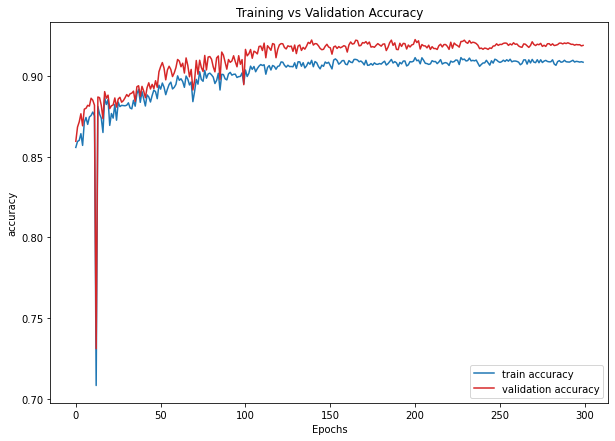

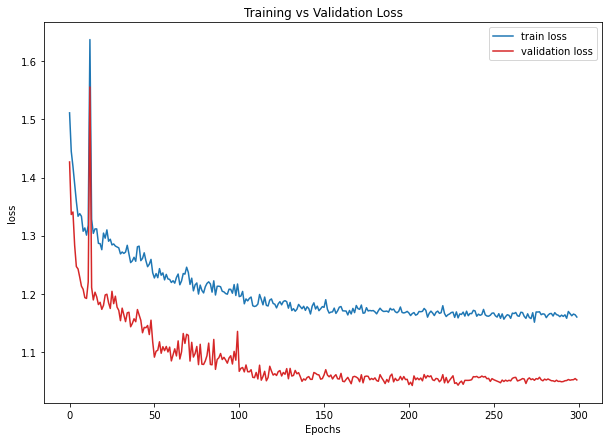

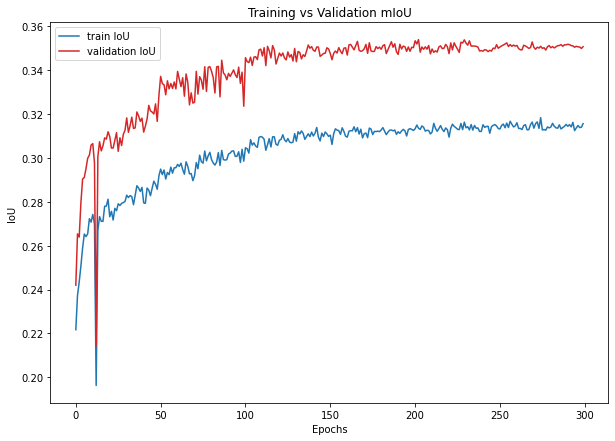

In [44]:
# Set random seeds and make CUDA operations deterministic for reproducible results across multiple runs
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Optimizer and Learning Rate Scheduler.
to_device(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.7)
epochs = 300

train_loop(model, train_data_loader, valid_data_loader, epochs, optimizer, scheduler, save_path, use_cel = False)

In [61]:
def inv_segmentation_map(outputs):
    """Converts model output tensors into a segmentation map."""
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    class_colors = np.array(CLASS_COLORS)

    # Create the segmentation map by indexing directly into class_colors
    segmentation_map = class_colors[labels]

    return segmentation_map

def make_predictions(image_sample, mask_sample):
    """Processes OCTA images to predict segmentation maps, evaluate model performance metrics, and visualize the results."""

    image_sample = torch.from_numpy(np.transpose(image_sample/255, (2, 0, 1))).float().unsqueeze(0)
    mask_sample_map = torch.nn.functional.one_hot(torch.tensor(mask_sample, dtype=torch.long), num_classes=6).permute(2, 3, 0, 1)

    # Model predictions and evaluations
    with torch.inference_mode():
        pred = model(to_device(image_sample))
    impred = nn.Softmax(dim=1)(pred)

    tp, fp, fn, tn = smp.metrics.get_stats(impred, to_device(mask_sample_map), mode='multilabel', threshold=0.5)
    iou_score_smp = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro", zero_division=1).item()
    iou_score_smp_N = smp.metrics.iou_score(tp, fp, fn, tn, reduction=None, zero_division=1)
    f1_score_smp = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro").item()
    accuracy_smp = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").item()
    accuracy_smp_N = smp.metrics.accuracy(tp, fp, fn, tn, reduction=None)

    iou_perclass_smp = iou_score_smp_N.tolist()[0]
    accuracy_perclass_smp = accuracy_smp_N.tolist()[0]

    mask_inv = inv_segmentation_map(mask_sample_map)
    impredinv = inv_segmentation_map(impred)

    # print('meanIOU (smp) = ', iou_score_smp)
    # print('IOU coef per class (smp) = ', iou_perclass_smp)

    plt.figure(figsize=(35, 35)).patch.set_facecolor('white')
    display_list = [Tensor2PILImage(image_sample.squeeze()), mask_inv, impredinv]
    titles=['OCTA', 'Ground Truth', 'Predicted\nAcc= '+str(np.around(accuracy_smp,4))+', meanIOU= '+str(np.around(iou_score_smp,4))+', IOU coef per class = '+str(np.around(iou_perclass_smp,4))]
    cmaps = ['gray', 'viridis', 'viridis']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        img_arr = display_list[i]
        plt.imshow(img_arr, cmap=cmaps[i], vmin=0, vmax=255)

    return impred

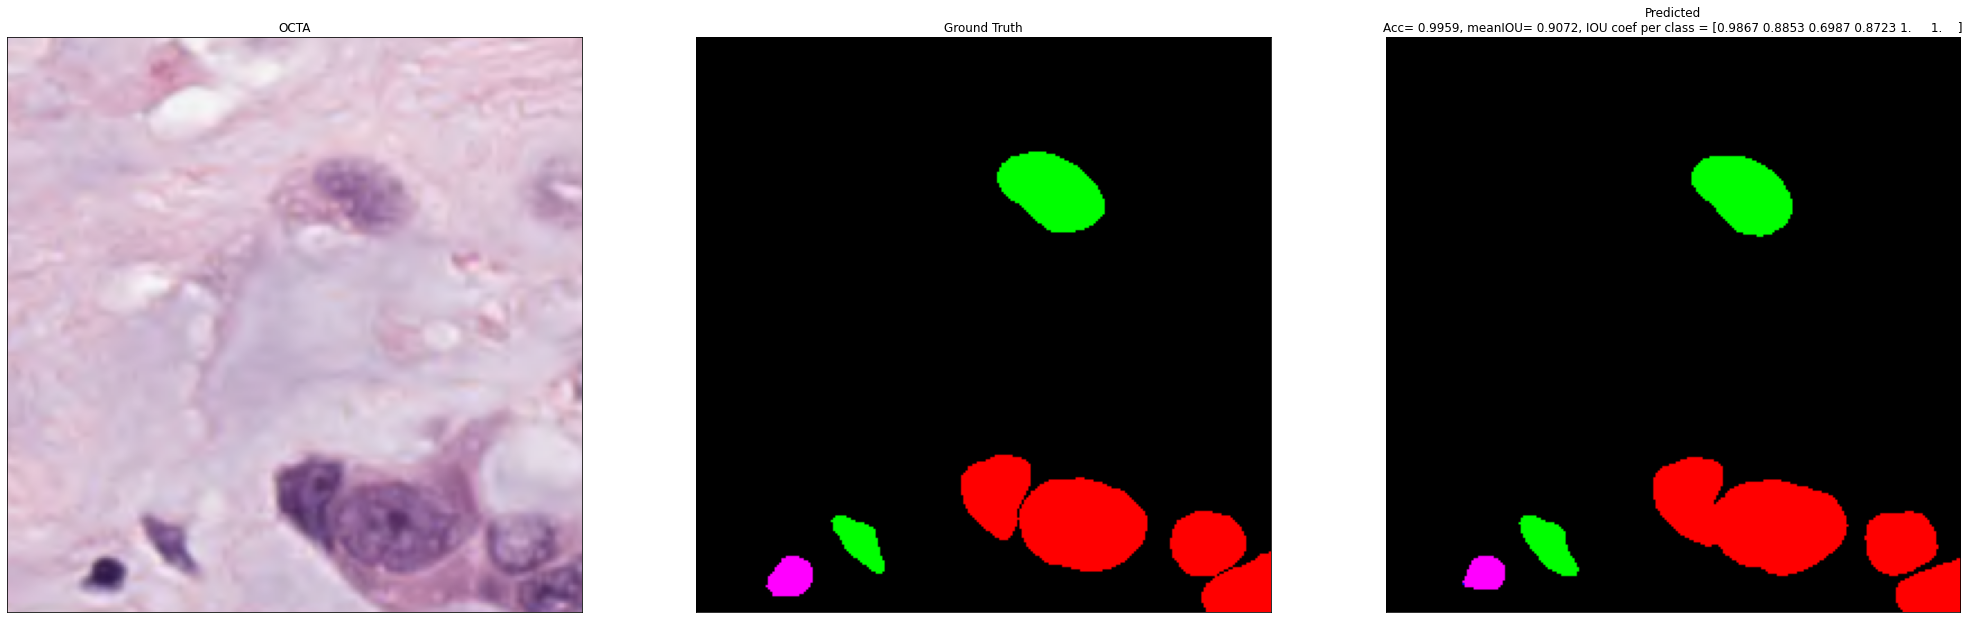

In [106]:
# Sample fron training dataset
image_sample_number = random.sample(range(train_images.shape[0]), 1)[0]


impred = make_predictions(train_images[image_sample_number], train_masks[image_sample_number])

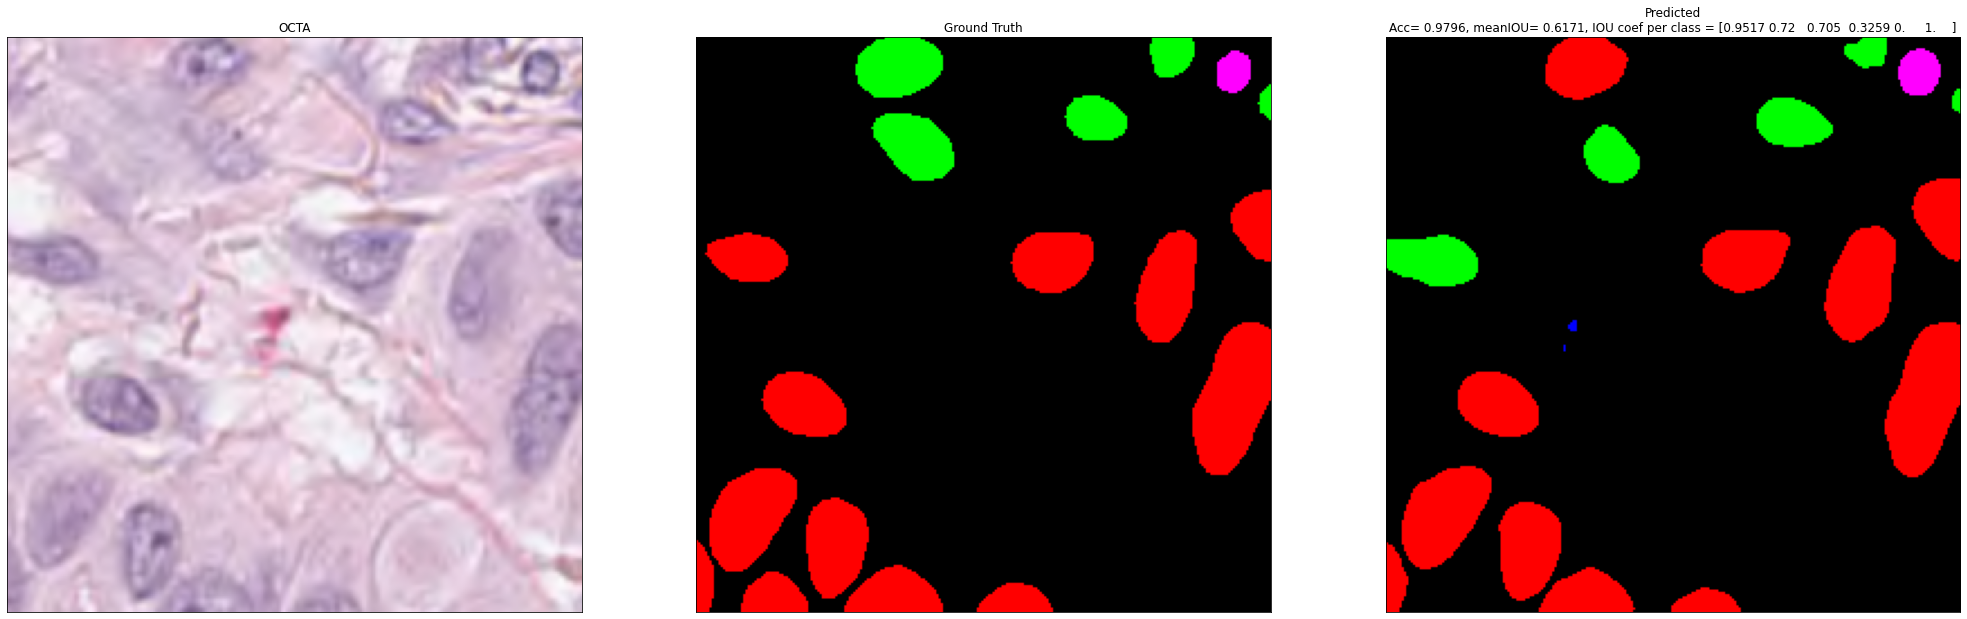

In [101]:
# Sample fron validation dataset
image_sample_number = random.sample(range(valid_images.shape[0]), 1)[0]

impred = make_predictions(valid_images[image_sample_number], valid_masks[image_sample_number])